# 4. Two Variable Functions

In [1]:
import numpy as np

from scipy.linalg import eig
from scipy.fft import fft2, ifft2

import matplotlib.pyplot as plt

In [2]:
def FourierD(N):
    row = np.arange(N)[:, None]
    col = np.arange(N)[None, :]
    x = 2 * np.pi * row / N
    h = (x[1] - x[0])[0]
    center = - np.pi**2 / (3 * h**2) - 1 / 6
    D1 = (row != col) * 0.5 * (-1)**(row + col) / np.tan(0.5 * ((row - col) * h) + (row == col))
    D2 = (row != col) * 0.5 * (-1)**(row + col + 1) / np.sin(0.5 * ((row - col) * h) + (row == col))**2 + center * (row == col)
    return x, D1, D2

def ChebyshevD(N):
    row = np.arange(N + 1)[:, None]
    col = np.arange(N + 1)[None, :]
    x = np.cos(np.pi * row / N)
    c = ((1 + (col % N == 0)) * (-1) ** col).T
    X = np.ones(N + 1) * x
    dX = X - X.T
    D = c @ (1 / c.T) / (dX + np.eye(N + 1))
    D1 = D - np.diag(np.sum(D, axis=1))
    D2 = D1@D1
    return x, D1, D2

def is_the_same(A, B):
    return np.max(np.abs(A - B)) < 1e-10

def aliased_index(k, N):
    return k - N * (k >= (N + 1)//2)

## 4.1. Lexicographic Ordering and the Kronecker Product

In [3]:
Nx = 30
Ny = 40
x_grid, D1x, D2x = FourierD(Nx)
y_grid, D1y, D2y = FourierD(Ny)

x_sq = x_grid @ np.ones((1, Ny))
y_sq = np.ones((Nx, 1)) @ y_grid.T
x    = x_sq.reshape((Nx * Ny, 1))
y    = y_sq.reshape((Nx * Ny, 1))

Dx = np.kron(D1x, np.eye(Ny))
Dy = np.kron(np.eye(Nx), D1y)

f   = np.exp(np.sin(x)) * np.exp(np.sin(y))
dxf = np.cos(x) * f
dyf = np.cos(y) * f

print('Derivative in x:', is_the_same(Dx @ f, dxf))
print('Derivative in y:', is_the_same(Dy @ f, dyf))

Derivative in x: True
Derivative in y: True


## 4.2 FFT Derivatives in 2 Dimensions

In [4]:
f_sq   = np.exp(np.sin(x_sq)) * np.exp(np.sin(y_sq))
dxf_sq = np.cos(x_sq) * f_sq
dyf_sq = np.cos(y_sq) * f_sq

wx_sq = aliased_index(np.arange(Nx)[:, None], Nx) @ np.ones((1, Ny))
wy_sq = np.ones((Nx, 1)) @ aliased_index(np.arange(Ny)[None, :], Ny)

wx_sq[Nx//2, :] = 0    #Here we kill the derivative of the Nyquist mode.
wy_sq[:, Ny//2] = 0    #This is equivalent to Trefethen's trick in page 23.

FFT_dxf = ifft2(1j * wx_sq * fft2(f_sq)).real
FFT_dyf = ifft2(1j * wy_sq * fft2(f_sq)).real

print('Derivative in x:', is_the_same(FFT_dxf, dxf_sq))
print('Derivative in y:', is_the_same(FFT_dyf, dyf_sq))

Derivative in x: True
Derivative in y: True


## 4.3. Polar Coordinates

In [5]:
def Laplacian(N, M):
    r, D1r, D2r = ChebyshevD(N)
    t, D1t, D2t = FourierD(M)
    
    D1rp = D1r[1:N//2 + 1, 1:N//2 + 1]   # First  radial derivative, positive r
    D1rn = D1r[1:N//2 + 1, N-1:N//2:-1]  # First  radial derivative, negative r
    D2rp = D2r[1:N//2 + 1, 1:N//2 + 1]   # Second radial derivative, positive r
    D2rn = D2r[1:N//2 + 1, N-1:N//2:-1]  # Second radial derivative, negative r
    
    R  = np.diag(1/r[1:N//2 + 1, 0])
    IZ = np.concatenate([np.eye(M//2), np.zeros((M//2, M//2))], axis = 1)
    ZI = np.concatenate([np.zeros((M//2, M//2)), np.eye(M//2)], axis = 1)
    T1 = np.concatenate([IZ, ZI], axis = 0)  # This is actually np.eye(M)
    T2 = np.concatenate([ZI, IZ], axis = 0)
    
    L = np.kron(D2rp + R @ D1rp, T1) + np.kron(D2rn + R @ D1rn, T2) + np.kron(R @ R, D2t)  # Laplacian operator

    return r[1:N//2 + 1], t, L

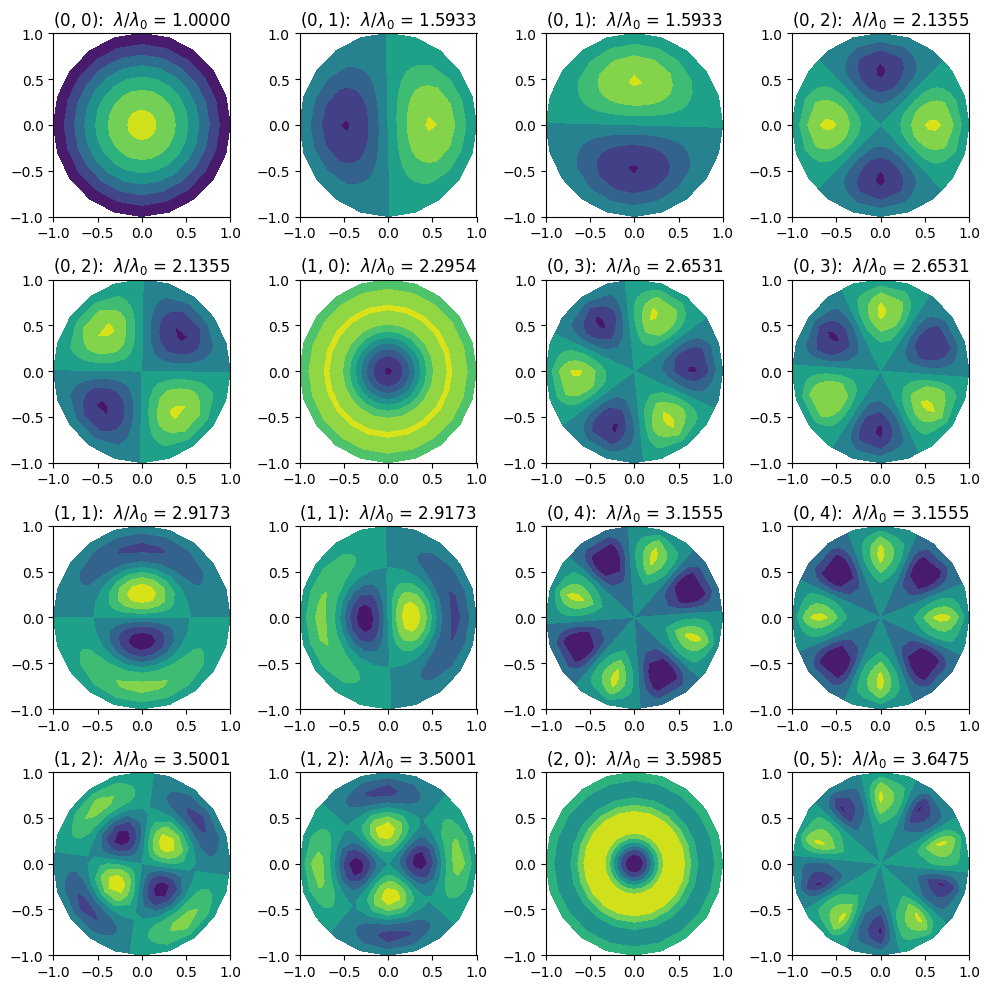

In [33]:
N = 35 # Number of points in Chebyshev radial grid
M = 20 # Number of points in Fourier angular grid
n = 4  # Number of modes per side of the grid

r, t, L = Laplacian(N,M)
lam2, V = eig(-L)

# Sort the eigenvalues and reshape
indices = np.argsort(lam2.real)
lam     = np.sqrt(lam2.real[indices])
V       = V[:, indices].reshape(N//2, M, (N//2)*M).real

# Prepare the full r and theta grids in matrix form 
rr = np.ones((M + 1, 1)) @ np.concatenate([[[1]], r.T, [[0]]], axis = 1)
tt = np.concatenate([t, [[2*np.pi]]], axis = 0) @ np.ones((1, N//2 + 2))

# Complete the theta angle by identifying psi(r, 2*pi) = psi(r, 0)
V = np.concatenate([V, V[:, [0], :]], axis = 1)

# Reintroduce the boundary points as psi(1, theta) = 0
V = np.concatenate([np.zeros((1, M + 1, (N//2)*M)), V], axis = 0)

# Add point at r=0 as the average value of the neighboring ones, for nicer plots.
V = np.concatenate([V, np.mean(V[[-1], :, :], axis = 1) * np.ones((1, M + 1, (N//2)*M))], axis = 0) 

# Index the solutions by counting the nodes in the t and theta directions.
r_nodes = np.sum((V[2:-1, [1], :] * V[1:-2, [1], :]) < 0, axis = 0).flatten()
t_nodes = np.sum((V[[1], 1:, :] * V[[1], :-1, :]) < 0, axis = 1).flatten() // 2

################################################################################
################################ PLOTTING PART #################################
################################################################################
fig, ax = plt.subplots(n, n, figsize = (10, 10));
plt.rc('font', size = 10)

for i in range(n):
    for j in range(n):
        ax[i, j].contourf(rr.T * np.cos(tt.T), rr.T * np.sin(tt.T), V[:, :, n*i + j])
        ax[i, j].set_title(f'({r_nodes[n*i + j]}, {t_nodes[n*i + j]}):  $\lambda$/$\lambda_0$ = {lam[n*i + j]/lam[0]:.4f}')
        
plt.tight_layout()
################################################################################